In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim

from geomloss import SamplesLoss

import numpy as np
import pandas as pd

import sklearn.preprocessing, sklearn.decomposition
import umap

from collections import Counter
from types import SimpleNamespace

import joblib
import json
import os
import random
import sys

In [2]:
sys.path.append("../../src")

%reload_ext autoreload
#%load_ext autoreload
%autoreload 2

import train as this
import klein as kl

import annoy

sys.path.append("..")
import spring_helper as sh

In [3]:
from tqdm.notebook import tqdm

In [4]:
import scipy.sparse
import sklearn
import umap

import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess dataset

## Raw data

In [6]:
expr = sh.load_npz("/data/gl/g2/sachit/data/klein/processed/counts_matrix_in_vitro.npz")
genes = sh.load_genes("/data/gl/g2/sachit/data/klein/processed/gene_names_in_vitro.txt")
highly_variable_genes = sh.filter_genes(expr)
cell_cycle_genes = [['Ube2c',
                    'Hmgb2',
                    'Hmgn2',
                    'Tuba1b', 
                    'Ccnb1', 
                    'Tubb5', 
                    'Top2a', 
                    'Tubb4b']]
non_cell_cycle_idx = sh.remove_corr_genes(expr, gene_list=genes, exclude_corr_genes_list=cell_cycle_genes, test_gene_idx=highly_variable_genes, min_corr=0.1)
non_cell_cycle_idx = non_cell_cycle_idx[0:2447]
# perform filtering
expr = expr[:, non_cell_cycle_idx]

use_genes = [genes[i] for i in non_cell_cycle_idx]

In [7]:
meta = pd.read_csv("/data/gl/g2/sachit/data/klein/spring/in_vitro/metadata.csv")
meta = meta.drop(meta.columns[0], axis = 1)
meta.head()

,Time point,Population,Annotation,Well,numeric_annotation
0,6.0,LK,undiff,2,1
1,6.0,LK,undiff,2,1
2,6.0,LK,Monocyte,2,2
3,6.0,LK,Neutrophil,2,3
4,6.0,LK,undiff,2,1


Scale and log data

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
x = expr.todense()
x = scaler.fit_transform(x) 

Load clonal data

In [9]:
base_dir = "../../ext/klein_Figure5_data_and_code/"

timepoints = np.load(base_dir + 'timepoints.npy')
neu_mo_mask = np.load(base_dir + 'neutrophil_monocyte_trajectory_mask.npy')
clonal_fate_matrix = np.load(base_dir + 'clonal_fate_matrix.npy')

PBA_predictions = np.load(base_dir + 'PBA_predictions.npy')
FateID_predictions = np.load(base_dir + 'FateID_predictions.npy')
WOT_predictions = np.load(base_dir + 'WOT_predictions.npy')

early_cells = np.load(base_dir + 'early_cells.npy')
heldout_mask = np.load(base_dir + 'heldout_mask.npy')

smoothed_groundtruth = np.load(base_dir + 'smoothed_groundtruth_from_heldout.npy')

has_fate_mask = np.all([clonal_fate_matrix[:,5:7].sum(1) > 0, neu_mo_mask[timepoints==2]],axis=0)
neu_vs_mo_percent = clonal_fate_matrix[has_fate_mask,5] / clonal_fate_matrix[has_fate_mask,5:7].sum(1)

heldout_mask_for_early_cells = (~heldout_mask)[early_cells[neu_mo_mask[timepoints==2]]]

predictions = []
predictions.append(smoothed_groundtruth[np.all([early_cells[neu_mo_mask[timepoints==2]], ~heldout_mask],axis=0)])

predictions.append(PBA_predictions[early_cells[neu_mo_mask[timepoints==2]]][heldout_mask_for_early_cells])
predictions.append(WOT_predictions[early_cells[neu_mo_mask[timepoints==2]]][heldout_mask_for_early_cells])
predictions.append(FateID_predictions[early_cells[neu_mo_mask[timepoints==2]]][heldout_mask_for_early_cells])

clonal_data_no_heldout = neu_vs_mo_percent[np.all([early_cells[neu_mo_mask[timepoints==2]], ~heldout_mask],axis=0)[has_fate_mask[neu_mo_mask[timepoints==2]]]]

has_fate_mask_for_early_heldout = has_fate_mask[np.all([neu_mo_mask[timepoints==2],early_cells],axis=0)][heldout_mask_for_early_cells]
predictions_filtered = [pred[has_fate_mask_for_early_heldout] for pred in predictions]

Visualize

In [10]:
pca = sklearn.decomposition.PCA(n_components = 50)
xp = pca.fit_transform(x)

um = umap.UMAP(n_components = 2, metric = 'euclidean', verbose = True, n_neighbors = 20)
xu = um.fit_transform(xp)
um.verbose = False

/data/gl/g5/yhtgrace/env/miniconda3/envs/pytorch1.4/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Thu Mar  5 22:46:22 2020 Finding Nearest Neighbors
Thu Mar  5 22:46:22 2020 Building RP forest with 23 trees
Thu Mar  5 22:46:23 2020 NN descent for 17 iterations
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
Thu Mar  5 22:46:49 2020 Finished Nearest Neighbor Search
Thu Mar  5 22:46:52 2020 Construct embedding
	completed  0  /  200 epochs
	complet

In [11]:
annot_order = list(meta['Annotation'].value_counts().sort_values(ascending = False).index)
annot_order

['undiff',
 'Neutrophil',
 'Monocyte',
 'Baso',
 'Mast',
 'Meg',
 'Lymphoid',
 'Erythroid',
 'Eos',
 'Ccr7_DC',
 'pDC']

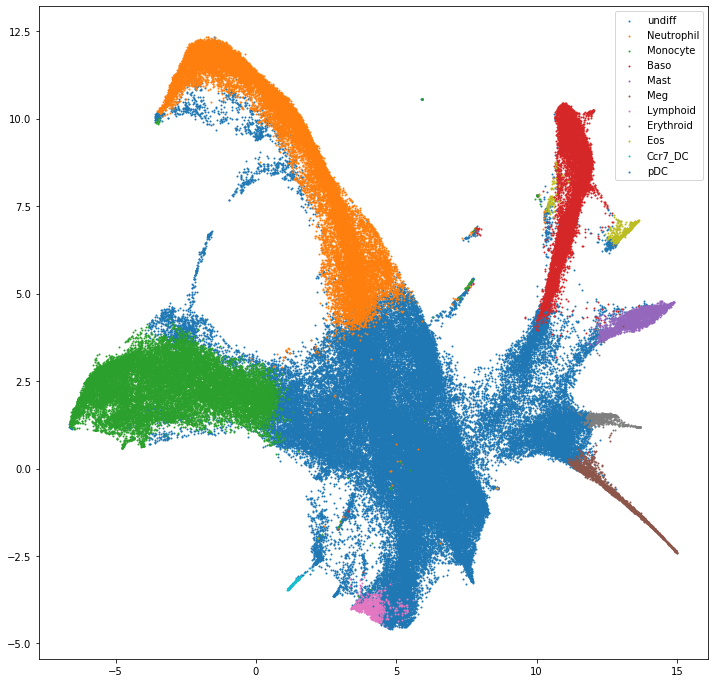

In [12]:
fig, ax = plt.subplots(figsize = (12, 12))
for a in annot_order: 
    px = meta['Annotation'] == a
    ax.scatter(xu[px, 0], xu[px, 1], s = 1, label = a)
ax.legend()

In [13]:
y = [2, 4, 6]
x_ = [torch.from_numpy(x[(meta['Time point'] == d),:]).float() for d in y]
xp_ = [torch.from_numpy(xp[(meta['Time point'] == d),:]).float() for d in y]
xu_ = [torch.from_numpy(xu[(meta['Time point'] == d),:]).float() for d in y]

In [14]:
torch.save({
    'data': pd.DataFrame(x, columns = use_genes), # smoothed
    'meta': meta, 
    'x': x_, 
    'xp': xp_, 
    'xu': xu_, 
    'y': y
}, '../../data/Klein2020_fate/fate_train.pt')

## Cell type classifier

In [15]:
yc = meta['Annotation']
yc = yc.mask(~((yc == 'Neutrophil') | (yc == 'Monocyte')), 'Other')
yc.value_counts()

Other         89468
Neutrophil    22237
Monocyte      19182
Name: Annotation, dtype: int64

In [16]:
xtr, xte, ytr, yte = sklearn.model_selection.train_test_split(xp, yc, stratify = yc)

In [17]:
n_trees = 10
n_neighbors = 20

t = annoy.AnnoyIndex(xtr.shape[1], 'euclidean')
for i in range(xtr.shape[0]): 
    t.add_item(i, xtr[i])
t.build(n_trees)

True

In [18]:
yp = []
for i in range(xte.shape[0]): 
    nn = ytr.iloc[t.get_nns_by_vector(xte[i], n_neighbors)]
    nn = Counter(nn.values).most_common(2)
    label, num = nn[0]
    yp.append(label)

In [19]:
print(sklearn.metrics.classification_report(yte, yp))

              precision    recall  f1-score   support

    Monocyte       0.97      0.98      0.98      4796
  Neutrophil       0.97      0.98      0.98      5559
       Other       0.99      0.99      0.99     22367

    accuracy                           0.98     32722
   macro avg       0.98      0.98      0.98     32722
weighted avg       0.98      0.98      0.98     32722



In [20]:
sklearn.metrics.f1_score(yte, yp, average = 'macro')

0.9800907945818662

Refit on all data

In [23]:
n_trees = 10
n_neighbors = 20

t = annoy.AnnoyIndex(xp.shape[1], 'euclidean')
for i in range(xp.shape[0]): 
    t.add_item(i, xp[i])
t.build(n_trees)

True

In [24]:
t.save('../../data/Klein2020_fate/50_20_10.ann')

True

In [25]:
with open("../../data/Klein2020_fate/50_20_10.txt", 'w') as f: 
    for yv in yc.values:
        f.write(yv + '\n')

## Test data

In [26]:
xp_te = xp[timepoints == 2][has_fate_mask][np.all([early_cells[neu_mo_mask[timepoints==2]], ~heldout_mask],axis=0)[has_fate_mask[neu_mo_mask[timepoints==2]]],:]
xp_te = torch.from_numpy(xp_te).float()

In [27]:
torch.save({
    'x': xp_te,
    't': y[-1] - y[0], 
    'y': clonal_data_no_heldout
}, '../../data/Klein2020_fate/fate_test.pt')

In [28]:
[x.std(axis = 0) for x in xp_]

[tensor([2.7113, 1.6116, 2.2672, 2.0096, 4.7179, 1.3839, 2.5427, 2.0160, 3.3728,
         1.9465, 1.8662, 2.1282, 2.2561, 2.0331, 2.0906, 1.8436, 1.8514, 1.8106,
         1.4266, 1.2652, 2.0445, 2.0297, 1.1930, 2.6262, 1.6157, 2.0058, 1.4263,
         1.4953, 2.0292, 1.7140, 1.4320, 2.2315, 1.5301, 1.6019, 1.6003, 1.6336,
         1.6819, 1.7646, 1.6286, 1.6322, 1.7325, 1.5819, 1.5256, 1.4757, 1.5032,
         1.6908, 1.6031, 1.4566, 1.4797, 1.5026]),
 tensor([6.2755, 4.9413, 5.0267, 2.7710, 3.4810, 2.8975, 2.9522, 2.8005, 2.8977,
         2.4500, 2.0271, 2.1920, 1.9066, 2.0426, 1.8124, 2.0723, 1.9759, 1.5973,
         1.7689, 1.7069, 1.7460, 1.7333, 1.5080, 1.1892, 1.5315, 1.5729, 1.3512,
         1.3316, 1.2888, 1.5212, 1.3872, 1.0817, 1.3307, 1.4224, 1.2859, 1.3934,
         1.2928, 1.2514, 1.2535, 1.2806, 1.2761, 1.3039, 1.2510, 1.2458, 1.1768,
         1.1282, 1.2047, 1.2640, 1.2181, 1.2622]),
 tensor([7.1838, 7.4601, 6.4814, 5.2219, 2.9594, 3.8939, 2.8961, 3.2393, 1.4546,
       